In [1]:
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import time
import glob
from lxml.html import parse
from sphfile import SPHFile
import pydub
import audiosegment
import pandas as pd
from collections import Counter
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)
sr = 16000

Unnamed: 0                                     177349
anchor_speaker                           Neil_Tickner
anchor_file         start_segments/j960617_seg196.npy
positive_file          end_segments/j960613cseg19.npy
negative_speaker                         Gary_Tuchman
negative_file         end_segments/eo970908seg104.npy
Name: 177349, dtype: object
0.17778048256553758
(128, 598)


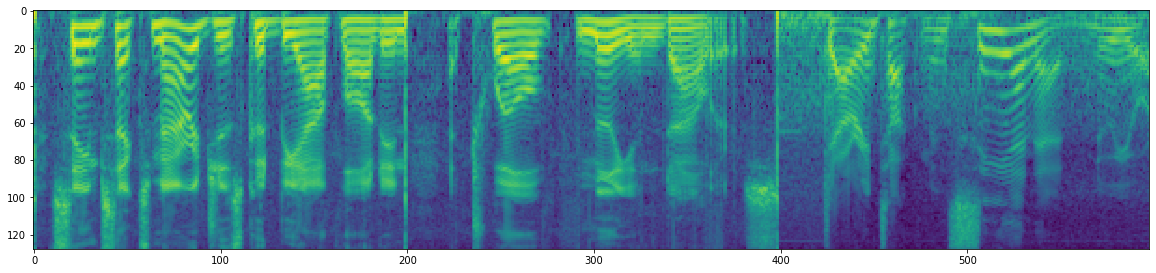

In [2]:
triplets = pd.read_csv('triplets.csv')
#triplets = triplets[triplets['anchor_speaker'] == 'i960711p_anchor2']
idx = np.random.randint(0, len(triplets))
triplet = triplets.iloc[idx]
anchor_segment = np.fromfile(triplet['anchor_file'], dtype = np.int16)/(2**15)
positive_segment = np.fromfile(triplet['positive_file'], dtype = np.int16)/(2**15)
negative_segment = np.fromfile(triplet['negative_file'], dtype = np.int16)/(2**15)
print(triplet)
print(anchor_segment.std())

S = librosa.feature.melspectrogram(np.concatenate((anchor_segment, positive_segment, negative_segment)), n_mels = 128, n_fft = 512, hop_length = 161) # 32 ms window, 10 ms hop
S_dB = librosa.power_to_db(S, ref=np.max)
print(S_dB.shape)
plt.figure(figsize = (20, 30))
plt.imshow(S_dB)
ipd.Audio(np.concatenate((anchor_segment, positive_segment, negative_segment)), rate = sr)


In [3]:
class SoundDataSet(torch.utils.data.Dataset):
    def __init__(self):
        self.triplets = pd.read_csv('triplets.csv')
    def __len__(self):
        return len(self.triplets)
    def __getitem__(self, idx):
        triplet = self.triplets.iloc[idx]
        anchor_segment = np.fromfile(triplet['anchor_file'], dtype = np.int16)/(2**15)
        positive_segment = np.fromfile(triplet['positive_file'], dtype = np.int16)/(2**15)
        negative_segment = np.fromfile(triplet['negative_file'], dtype = np.int16)/(2**15)
        return self.make_spectrogram(anchor_segment), self.make_spectrogram(positive_segment), self.make_spectrogram(negative_segment)
    def make_spectrogram(self, segment):
        S = librosa.feature.melspectrogram(segment, n_mels = 128, n_fft = 512, hop_length = 161) # 32 ms window, 10 ms hop
        return librosa.power_to_db(S, ref=np.max).T[None, :, :] # add channel dimension
trainset = SoundDataSet()
trainset[0][0].shape

(1, 200, 128)

## Causal version, slow, maybe try torch jit

In [4]:
class Spectral_Attention(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(Spectral_Attention, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.cell = nn.LSTM(input_size, hidden_size, num_layers, batch_first = False)
        self.attention = nn.Linear(hidden_size*num_layers, input_size) # can replace this with better attention mechanism
    def zero_state(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size).cuda(),
                torch.zeros(self.num_layers, batch_size, self.hidden_size).cuda())
    def forward(self, X, prev_state = None, mask = None): # X: (sequence length, batch, hidden size)
        batch_size = X.shape[1]
        if prev_state == None: # if we don't initialize hidden state
            prev_state = self.zero_state(batch_size)
        if mask == None:
            mask = torch.ones(batch_size, self.input_size).cuda()
        outputs = []
        for t, x in enumerate(X):
            x = x*mask
            x = x[None, ...] # 1, batch, hidden_size
            output, (state_h, state_c) = self.cell(x, prev_state)
            prev_state = (state_h, state_c)
            state_h = state_h.view(batch_size, -1)
            mask = self.attention(state_h)
            outputs.append(output)
        outputs = torch.cat(outputs, dim = 0)
        return outputs

## Noncausal version with Residual Attention

In [9]:
import torch
import torch.nn as nn
from torch.nn import init
import functools
from torch.autograd import Variable
import numpy as np

class ResidualBlock(nn.Module):
    def __init__(self, input_channels, output_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.stride = stride
        self.bn1 = nn.BatchNorm2d(input_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(input_channels, output_channels//4, 1, 1, bias = False)
        self.bn2 = nn.BatchNorm2d(output_channels//4)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(output_channels//4, output_channels//4, 3, stride, padding = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(output_channels//4)
        self.relu = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(output_channels//4, output_channels, 1, 1, bias = False)
        self.conv4 = nn.Conv2d(input_channels, output_channels , 1, stride, bias = False)
        
    def forward(self, x):
        residual = x
        out = self.bn1(x)
        out1 = self.relu(out)
        out = self.conv1(out1)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv3(out)
        if (self.input_channels != self.output_channels) or (self.stride !=1 ):
            residual = self.conv4(out1)
        out += residual
        return out

class AttentionModule_stage1(nn.Module):
    # input size is 56*56
    def __init__(self, in_channels, out_channels, size1=(200, 128), size2=(100, 64), size3=(50, 32)):
        super(AttentionModule_stage1, self).__init__()
        self.first_residual_blocks = ResidualBlock(in_channels, out_channels)

        self.trunk_branches = nn.Sequential(
            ResidualBlock(in_channels, out_channels),
            ResidualBlock(in_channels, out_channels)
         )

        self.mpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.softmax1_blocks = ResidualBlock(in_channels, out_channels)

        self.skip1_connection_residual_block = ResidualBlock(in_channels, out_channels)

        self.mpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.softmax2_blocks = ResidualBlock(in_channels, out_channels)

        self.skip2_connection_residual_block = ResidualBlock(in_channels, out_channels)

        self.mpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.softmax3_blocks = nn.Sequential(
            ResidualBlock(in_channels, out_channels),
            ResidualBlock(in_channels, out_channels)
        )

        self.interpolation3 = nn.UpsamplingBilinear2d(size=size3)

        self.softmax4_blocks = ResidualBlock(in_channels, out_channels)

        self.interpolation2 = nn.UpsamplingBilinear2d(size=size2)

        self.softmax5_blocks = ResidualBlock(in_channels, out_channels)

        self.interpolation1 = nn.UpsamplingBilinear2d(size=size1)

        self.softmax6_blocks = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels , kernel_size = 1, stride = 1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels , kernel_size = 1, stride = 1, bias = False),
            nn.Sigmoid()
        )

        self.last_blocks = ResidualBlock(in_channels, out_channels)

    def forward(self, x):
        #batch_size, nheads, length, n_mels = x.shape
        x = self.first_residual_blocks(x)
        out_trunk = self.trunk_branches(x)
        out_mpool1 = self.mpool1(x) # 100x64
        out_softmax1 = self.softmax1_blocks(out_mpool1)
        out_skip1_connection = self.skip1_connection_residual_block(out_softmax1)
        out_mpool2 = self.mpool2(out_softmax1) # 50x32
        out_softmax2 = self.softmax2_blocks(out_mpool2)
        out_skip2_connection = self.skip2_connection_residual_block(out_softmax2)
        out_mpool3 = self.mpool3(out_softmax2) # 25x16
        out_softmax3 = self.softmax3_blocks(out_mpool3) 
        #
        out_interp3 = self.interpolation3(out_softmax3) + out_softmax2
        # print(out_skip2_connection.data)
        # print(out_interp3.data)
        out = out_interp3 + out_skip2_connection
        out_softmax4 = self.softmax4_blocks(out)
        out_interp2 = self.interpolation2(out_softmax4) + out_softmax1
        out = out_interp2 + out_skip1_connection
        out_softmax5 = self.softmax5_blocks(out)
        out_interp1 = self.interpolation1(out_softmax5) + out_trunk
        out_softmax6 = self.softmax6_blocks(out_interp1)
        out = (1 + out_softmax6) * out_trunk
        out_last = self.last_blocks(out)
        return out_last

num_heads = 4
net = nn.Sequential(nn.Conv2d(1, num_heads, kernel_size=3, stride=1, padding=1, bias = False),
                    nn.BatchNorm2d(num_heads),
                    nn.ReLU(inplace=True),
                    AttentionModule_stage1(num_heads, num_heads),  # batch_size * num_heads * 200 *128
                    Lambda(lambda x: x.permute((0, 2, 1, 3)).contiguous().view(x.shape[0], x.shape[2], -1)), # batch_size * 200 * (num_heads*128)
                    nn.LSTM(num_heads*128, 256, 3, batch_first = True, bidirectional = True), # batch_size * 200 * n_hidden
                    Lambda(lambda x: x[0].mean(dim = 1)), # batch * n_hidden
                    nn.Linear(512, 256),
                    nn.Tanh(),
                    nn.Linear(256, 128),
                    nn.Tanh(), # batch * n_hidden
                    Lambda(lambda x: torch.nn.functional.normalize(x, 2, 1)) # L2 normalize across n_hidden
                    ).cuda()
#half precision
net.half()  # convert to half precision
for layer in net.modules():
    if isinstance(layer, nn.BatchNorm2d):
        layer.float()



S = librosa.feature.melspectrogram(anchor_segment, n_mels = 128, n_fft = 512, hop_length = 161) # 32 ms window, 10 ms hop
S_dB = librosa.power_to_db(S, ref=np.max)
X = S_dB[None, None, ...]
X = torch.Tensor(X).permute((0, 1, 3, 2)).cuda().half()
out = net(X)
print(out.shape)

torch.Size([1, 128])


## Runtime test

In [6]:
# runtime test
dummy = nn.Sequential(nn.LSTM(128, 256, 3, batch_first = True, bidirectional=True),
                      Lambda(lambda x: x[0].mean(dim = 1)),
                      nn.Linear(512, 256),
                      nn.Tanh(),
                      nn.Linear(256, 128),
                      nn.Tanh()
                      ).cuda()
#net = Spectral_Attention(128, 512, 3).cuda()
loss = torch.nn.MSELoss(size_average=512, reduce=None, reduction='mean')
optim1 = torch.optim.Adam(dummy.parameters())
optim2 = torch.optim.Adam(net.parameters())
target = torch.zeros(1, 128).cuda()

begin = time.time()
out1 = dummy(X[0])
loss1 = loss(out1, target)
loss1.backward()
optim1.step()
print(time.time()-begin)

begin = time.time()
out2 = net(X)
loss2 = loss(out2, target)
loss2.backward()
optim2.step()
print(time.time()-begin)


0.04322052001953125
0.06951665878295898


/home/joseph/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


## Things to try: Maybe add a multi-headed timewise attention to LSTM output? See if it focuses on attack of sounds? Averaging sounds rough

In [19]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, pin_memory = True)
optimizer = torch.optim.Adam(net.parameters(), 0.001)
lasttime = time.time()
for epoch in range(30):
    running_loss = 0.0
    for batch_idx, (X_anchor, X_pos, X_neg) in enumerate(trainloader):
        #optimizer.zero_grad()
        X_anchor, X_pos, X_neg = X_anchor.cuda().half(), X_pos.cuda().half(), X_neg.cuda().half()
        print(X_anchor.shape)
        out_anchor, X_pos, X_neg = net(X_anchor), net(X_pos), net(X_neg)
        #loss = criterion(outputs, labels)
        #loss.backward()
        #optimizer.step()



        #running_loss += loss.item()
        #if i % 10 == 9:    # print every 2000 mini-batches
        #    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
        #    running_loss = 0.0
        #measure time
        print('batch time: ', str(time.time()-lasttime)[:4])
        lasttime = time.time()


torch.Size([32, 1, 200, 128])
batch time:  0.32
torch.Size([32, 1, 200, 128])
batch time:  0.29
torch.Size([32, 1, 200, 128])
batch time:  0.30
torch.Size([32, 1, 200, 128])
batch time:  0.30
torch.Size([32, 1, 200, 128])
batch time:  0.29
torch.Size([32, 1, 200, 128])
batch time:  0.29
torch.Size([32, 1, 200, 128])
batch time:  0.29
torch.Size([32, 1, 200, 128])
batch time:  0.29
torch.Size([32, 1, 200, 128])
batch time:  0.31
torch.Size([32, 1, 200, 128])
batch time:  0.29
torch.Size([32, 1, 200, 128])
batch time:  0.29
torch.Size([32, 1, 200, 128])


KeyboardInterrupt: 